# 问题分析

  **流浪地球在截至目前票房已达到46亿，成为中国电影史上票房第二高的电影。电影自春节上映开始，由流浪地球延申关于国产科幻电影等相关话题的热度一直很高。而2月20日左右社交媒体上开始有流浪地球在豆瓣被恶意一分的新闻出现，将流浪地球的讨论热度推向最高点**。

### 本文尝试对流浪地球的在豆瓣的评分和评论等数据进行分析，以期得回答以下问题:
- 1.流浪地球在豆瓣的真实评分状况如何。
- 2.流浪地球的争议程度如何，不同分段的用户对于流浪地球的真实感受有何不同。

#### 引入相关包和绘图参数设置

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

large = 22; med = 16; small = 12
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题-设置字体为黑体
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
         'font.sans-serif':'SimHei',
         'axes.unicode_minus':False}
plt.rcParams.update(params)

plt.style.use('seaborn-whitegrid')
sns.set_style('white')

# 数据清洗

### 读取爬虫得到的原始数据并进行查看

In [2]:
df = pd.read_json('DouBanMovies_Raw.json')
df=df.reindex().sort_index()
df[:1]

,ReleaseDate,ScreenWriter,comments,descriptions,director,rating_of_5stars,score,title,type,url,votes,year
0,[1984-05-23],[雅克·杜瓦隆],[全部 29 条],[\n 导演: 雅克·杜瓦隆\n 编剧: 雅克·杜瓦隆\n ...,[雅克·杜瓦隆],"[8.5%, 16.9%, 44.1%, 25.4%, 5.1%]",[6.0],[海盗 La pirate],[剧情],[https://movie.douban.com/subject/4238659/],[75],[(1984)]


### 数据格式及字段待处理点:

#### 1.所有元素的格式都为str(s) of list,需要转换成相应的type。2.descriptions内包含部分需要提取的字段:语言，片长，上映日期等。3.'type'等分类型数据需要根据需要进行one-hot转换。

### 对原始数据进行转换清洗

In [3]:
# 定义从describtions和date两列中提取所需字段的两个函数

import re
def extract_date(full_str):
    '''
    从year字段中提取数字部分
    '''
    pattern=re.compile('[\d+\-+]+')
    date_list=list(re.findall(pattern,full_str))
    date = date_list[0]
    return date
def extract(element_str,element_name):
    '''
    从element_str中提取element_name的内容
    '''
    element_str=str(element_str)
    splited_str=element_str.replace(' ','').split('\n')
    #用于存放元素名称-元素内容的字典
    element_dict={}
    for pair in splited_str:
        splited_list=pair.split(':',maxsplit=1)
        key=splited_list[0].replace(' ','')
        if len(splited_list)==2:
            value=splited_list[1].replace(' ','')
        else:
            value=None
        element_dict[key]=value
    if element_name in element_dict:
        return element_dict[element_name]
    else:
        return None

#### 将各列的数据从List转换为对应的数据格式
#### 将votes,comments,score的数据类型转换成int:暂时未处理NoneType数据，因此无法使用astype转换每列的数据类型

In [4]:
df=df.applymap(lambda i:','.join(j for j in i) if type(i)==list else i)

df['minutes']=df['descriptions'].apply(extract,args=('片长',)).str.extract('(\d+)')[0]
df['minutes']=df['minutes'].apply(lambda i:int(i) if type(i)==str else i)

df['comments']=df['comments'].str.extract('(\d+)')[0]
df['comments']=df['comments'].apply(lambda i:int(i) if type(i)==str else i)

df['votes']=df['votes'].apply(lambda i:int(i) if type(i)==str else i)
df['score']=df['score'].apply(lambda i:float(i) if type(i)==str else i)
df['year']=df['year'].str.extract('(\d+)')[0]


df['language']=df['descriptions'].apply(extract,args=('语言',))
df['actors']=df['descriptions'].apply(extract,args=('主演',))
df['country']=df['descriptions'].apply(extract,args=('制片国家/地区',))

#时间为空的设置为未来时间2020-01-01，标记为异常值
df['ReleaseDate']=df['ReleaseDate'].fillna('2020-01-01')
df['ReleaseDate']=df['ReleaseDate'].apply(extract_date)
df['FullDate']=df['ReleaseDate'].apply(lambda i:1 if len(i)>4 else 0)
df['ReleaseDate']=pd.to_datetime(df['ReleaseDate'])

### 对country,language,type三列分类型数据整理：合并同义字段

#### 对country整理

In [5]:
countries=[]
for i in df.country:
    i=str(i)
    countries.extend(i.split('/'))
countries=pd.DataFrame(countries)
dd=countries.groupby(0).agg('size')
dd[dd>20].sort_values(ascending=False).index

Index(['美国', '日本', '中国大陆', '法国', '香港', '英国', '德国', '韩国', '意大利', '加拿大', '台湾',
       '西班牙', '印度', '澳大利亚', '比利时', '泰国', '瑞典', '俄罗斯', '荷兰', '西德', '丹麦', '苏联',
       '波兰', '瑞士', '墨西哥', '爱尔兰', '阿根廷', '巴西', '奥地利', 'USA', '挪威', '捷克', '匈牙利',
       '中国', '芬兰', '罗马尼亚', '以色列', '新加坡', '伊朗', '葡萄牙', 'None', '南非', '土耳其',
       '捷克斯洛伐克', '希腊', '新西兰', 'UK', '卢森堡', '南斯拉夫', '菲律宾', '马来西亚', '冰岛',
       'Czechoslovakia', '印度India', '智利', '保加利亚', '越南', '加拿大Canada', 'Canada',
       '乌克兰', '塞尔维亚', '克罗地亚', '斯洛伐克', '爱沙尼亚', '哥伦比亚', 'Luxembourg', '立陶宛',
       '卡塔尔', '斯洛文尼亚', '摩洛哥', '古巴', 'Bulgaria'],
      dtype='object', name=0)

In [6]:
older_values=['印度India', '中国大陆', 'USA', 'UK', 'Czechoslovakia', 'Luxembourg', '加拿大Canada', 'Canada','Bulgaria']
values=['印度', '中国', '美国', '英国', '捷克斯洛伐克', '卢森堡', '加拿大', '加拿大','保加利亚']
for old_value,value in zip(older_values,values):
    df['country']=df['country'].str.replace(old_value,value)
countries=[]
for i in df.country:
    i=str(i)
    countries.extend(i.split('/'))
countries=pd.DataFrame(countries)
dd=countries.groupby(0).agg('size')
dd[dd>20].sort_values(ascending=False).index

Index(['美国', '日本', '中国', '法国', '香港', '英国', '德国', '韩国', '意大利', '加拿大', '台湾',
       '西班牙', '印度', '澳大利亚', '比利时', '泰国', '瑞典', '俄罗斯', '荷兰', '西德', '丹麦', '苏联',
       '波兰', '瑞士', '墨西哥', '爱尔兰', '阿根廷', '巴西', '奥地利', '挪威', '捷克', '匈牙利',
       '捷克斯洛伐克', '芬兰', '罗马尼亚', '新加坡', '以色列', '伊朗', '葡萄牙', 'None', '卢森堡', '南非',
       '土耳其', '希腊', '新西兰', '南斯拉夫', '菲律宾', '保加利亚', '马来西亚', '冰岛', '智利', '越南',
       '乌克兰', '塞尔维亚', '克罗地亚', '斯洛伐克', '爱沙尼亚', '哥伦比亚', '立陶宛', '卡塔尔', '斯洛文尼亚',
       '摩洛哥', '古巴'],
      dtype='object', name=0)

#### 对language整理

In [7]:
languages=[]
for i in df.language:
    i=str(i)
    languages.extend(i.split('/'))
languages=pd.DataFrame(languages)
dd=languages.groupby(0).agg('size')
dd[dd>20].sort_values(ascending=False).index

Index(['英语', '汉语普通话', '日语', '法语', '粤语', '德语', '韩语', '西班牙语', '意大利语', '俄语',
       '普通话', '国语', 'None', '泰语', '葡萄牙语', '波兰语', '阿拉伯语', '瑞典语', 'English',
       '印地语', '北印度语', '丹麦语', '捷克语', '荷兰语', '希伯来语', '无对白', '土耳其语', '闽南语', '波斯语',
       '拉丁语', '匈牙利语', '希腊语', '挪威语', '罗马尼亚语', '芬兰语', '越南语', '菲律宾语', '斯洛伐克语',
       '乌尔都语', '塞尔维亚语', '上海话', '加泰罗尼亚语', '格鲁吉亚语', '塔加路语', 'Serbian', '中文',
       '印地语Hindi', '乌克兰语', '藏语', '美国手语', '朝鲜语', '塞尔维亚-克罗地亚语', '泰米尔语',
       'english', '冰岛语', '保加利亚语', '四川话', '孟加拉语', '意第绪语', '马来语', '瑞士德语', '泰卢固语',
       '依地语', '爱沙尼亚语', '阿尔巴尼亚语', '印尼语'],
      dtype='object', name=0)

In [8]:
old_values=['Serbian','中文','国语','印地语Hindi','English','english']
new_values=['塞尔维亚语','汉语普通话','汉语普通话','印度语','英语','英语']

for old_value,new_value in zip(old_values,new_values):
    df['language']=df['language'].str.replace(old_value,new_value)
    
languages=[]
for i in df.language:
    i=str(i)
    languages.extend(i.split('/'))
languages=pd.DataFrame(languages)
dd=languages.groupby(0).agg('size')
dd[dd>20].sort_values(ascending=False).index

Index(['英语', '汉语普通话', '日语', '法语', '粤语', '德语', '韩语', '西班牙语', '意大利语', '俄语',
       '普通话', 'None', '泰语', '葡萄牙语', '波兰语', '瑞典语', '阿拉伯语', '印地语', '北印度语', '丹麦语',
       '捷克语', '荷兰语', '希伯来语', '无对白', '土耳其语', '闽南语', '波斯语', '拉丁语', '匈牙利语', '希腊语',
       '挪威语', '罗马尼亚语', '芬兰语', '塞尔维亚语', '越南语', '菲律宾语', '斯洛伐克语', '乌尔都语', '上海话',
       '印度语', '加泰罗尼亚语', '格鲁吉亚语', '塔加路语', '藏语', '乌克兰语', '美国手语', '朝鲜语',
       '塞尔维亚-克罗地亚语', '泰米尔语', '冰岛语', '保加利亚语', '四川话', '孟加拉语', '意第绪语', '马来语',
       '瑞士德语', '泰卢固语', '依地语', '爱沙尼亚语', '阿尔巴尼亚语', '印尼语'],
      dtype='object', name=0)

##### 对generes进行转换

In [9]:
genres=[]
for i in df.type:
    i=str(i)
    genres.extend(i.split(','))
genres=pd.unique(genres)
genres

array(['剧情', '恐怖', '古装', '喜剧', '动作', '科幻', '战争', '惊悚', '犯罪', 'None', '家庭',
       '冒险', '爱情', '动画', '音乐', '奇幻', '历史', '黑色电影', '歌舞', '传记', '悬疑', '戏曲',
       '儿童', '武侠', '西部', '运动', '鬼怪', '荒诞', '舞台艺术', '同性', '情色', 'Adult',
       '灾难', '悬念', '惊栗', '脱口秀', '真人秀', 'Comedy', 'Talk-Show',
       'Reality-TV', '记录', '愛情 Romance', '音樂 Music', '動畫 Animation', '短片',
       '動作 Action', '紀錄片 Documentary', '驚悚 Thriller'], dtype=object)

In [10]:
old_values=['Reality-TV','Talk-Show','惊栗','愛情 Romance','音樂 Music',
            '悬念','動畫 Animation','紀錄片 Documentary','驚悚 Thriller','Comedy','動作 Action']
new_values=['真人秀','脱口秀','惊悚','爱情','音乐',
           '悬疑','动画','记录','惊悚','喜剧','动作']
for old_value,new_value in zip(old_values,new_values):
    df['type']=df['type'].str.replace(old_value,new_value)
    
genres=[]
for i in df.type:
    i=str(i)
    genres.extend(i.split(','))
genres=pd.unique(genres)
genres

array(['剧情', '恐怖', '古装', '喜剧', '动作', '科幻', '战争', '惊悚', '犯罪', 'None', '家庭',
       '冒险', '爱情', '动画', '音乐', '奇幻', '历史', '黑色电影', '歌舞', '传记', '悬疑', '戏曲',
       '儿童', '武侠', '西部', '运动', '鬼怪', '荒诞', '舞台艺术', '同性', '情色', 'Adult',
       '灾难', '脱口秀', '真人秀', '记录', '短片'], dtype=object)

### 将rating_of_5stars分成对应各分段评分的五列

In [11]:
df=df.dropna()
for i in range(5):
    column_name = 'prop_of_{}_star'.format(5-i)
    df[column_name]=df['rating_of_5stars'].apply(lambda ele:float(ele.split(',')[i].strip('%')))

### 舍弃已完成数据提取的describtion和rating列

In [12]:
df.drop(['descriptions','rating_of_5stars'],inplace=True,axis=1)

### 查看整理后的数据类型和数据内容

In [13]:
print('当前数据类型:\n',df.dtypes)
df[:3]

当前数据类型:
 ReleaseDate       datetime64[ns]
ScreenWriter              object
comments                 float64
director                  object
score                    float64
title                     object
type                      object
url                       object
votes                    float64
year                      object
minutes                  float64
language                  object
actors                    object
country                   object
FullDate                   int64
prop_of_5_star           float64
prop_of_4_star           float64
prop_of_3_star           float64
prop_of_2_star           float64
prop_of_1_star           float64
dtype: object


,ReleaseDate,ScreenWriter,comments,director,score,title,type,url,votes,year,minutes,language,actors,country,FullDate,prop_of_5_star,prop_of_4_star,prop_of_3_star,prop_of_2_star,prop_of_1_star
0,1984-05-23,雅克·杜瓦隆,29.0,雅克·杜瓦隆,6.0,海盗 La pirate,剧情,https://movie.douban.com/subject/4238659/,75.0,1984,88.0,法语/英语,简·伯金/玛鲁施卡·迪特马斯/PhilippeLéotard,法国,1,8.5,16.9,44.1,25.4,5.1
1,1988-01-01,"林义雄,杜文波",9.0,杜文波,3.3,猛鬼医院 猛鬼醫院,恐怖,https://movie.douban.com/subject/3339326/,54.0,1988,79.0,粤语,谷峰/关海山/梁小龙/何柏光/车保罗/曾楚霖/江岛/杜少明/鱼头云,香港,0,0.0,3.2,16.1,22.6,58.1
3,1974-04-22,约瑟夫·W·萨诺,22.0,约瑟夫·W·萨诺,2.9,深喉2 Deep Throat Part II,喜剧,https://movie.douban.com/subject/3162430/,68.0,1974,88.0,英语,LindaLovelace/HarryReems/LeviRichards,美国,1,0.0,2.4,9.8,19.5,68.3


# 数据分析

## 1.流浪地球在豆瓣的真实评分状况如何，是否被恶意评分。

### 方法:尝试查看同段分数的评分分布进行分析

#### 数据准备

#### 1）将数据转换成长数据以便seaborn和matplotlib使用

In [14]:
df['score_cut']=pd.cut(df['score'],[2,4,6,7.7,8.1,10],labels=['(2,4]','(4,6]','(6,7.7]','(7.7,8.1]','(8.1,10]'])
#df_cut=df.groupby('score_cut').agg('sum')[['prop_of_5_star','prop_of_4_star','prop_of_3_star','prop_of_2_star','prop_of_1_star',]]
df_stack=df[['prop_of_1_star','prop_of_2_star','prop_of_3_star','prop_of_4_star','prop_of_5_star','score_cut','title']].set_index(['score_cut','title'])
df_stack=df_stack.stack().reset_index()
df_stack.rename(columns={'level_2':'score',0:'values'},inplace=True)
df_stack.head()

,score_cut,title,score,values
0,"(4,6]",海盗 La pirate,prop_of_1_star,5.1
1,"(4,6]",海盗 La pirate,prop_of_2_star,25.4
2,"(4,6]",海盗 La pirate,prop_of_3_star,44.1
3,"(4,6]",海盗 La pirate,prop_of_4_star,16.9
4,"(4,6]",海盗 La pirate,prop_of_5_star,8.5


#### 2）为流浪地球单独创建一个category数值，以便绘图。

In [15]:
df_stack['score_cut']=df_stack['score_cut'].astype('str')
#df_stack[df_stack['title'].str.contains('流浪地球')]
df_stack.loc[[158405,158406,158407,158408,158409],['score_cut']]='EARTH(7.9)'
df_stack['score_cut']=df_stack['score_cut'].astype('category')

#### 3)绘图总体评分分布和流浪地球的评分分布：Earth为流浪地球的评分数量分布

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


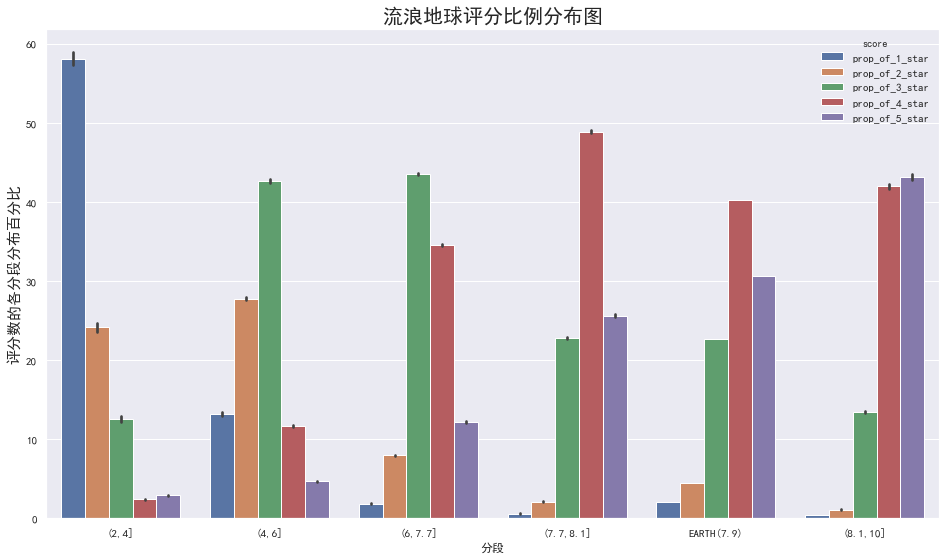

In [16]:
sns.set_style('white')
#显示中文字体
sns.set(font='simhei')
fig,ax=plt.subplots(figsize=(16,9))
sns.barplot(data=df_stack,x='score_cut',y='values',hue='score',
           order=['(2,4]','(4,6]','(6,7.7]','(7.7,8.1]','EARTH(7.9)','(8.1,10]']
           )
#sns.barplot(data=df_earth,x='score_cut',y='values',hue='score',ax=ax[1])
# Decoration
plt.subplots_adjust(wspace=0)
plt.title('流浪地球评分比例分布图',fontsize=20)
plt.ylabel('评分数的各分段分布百分比',fontsize=15)
plt.xlabel('分段')
plt.show()

#### 4)结论：可以明显看到相对同分段电影，流浪地球的评分比例在一星，二星，五星偏高，而四星明显偏低，三星差距不明显。

# Q2:流浪地球的争议程度如何，给出不同评分的用户间的感受与争议点在哪。

### 先查看两组数据:流浪地球的评论数和评分数

In [17]:
df[df['title'].str.contains('流浪地球')][['votes','comments']]

,votes,comments
42087,1016428.0,473811.0


In [18]:
p_comments=stats.percentileofscore(df['comments'],473811.0)
p_votes=stats.percentileofscore(df['votes'],1016428.0)
print('流浪地球的在全部电影中的评论数和评分数的百分位分别为{:.4f}%,{:.4f}%:'.format(p_comments,p_votes))

流浪地球的在全部电影中的评论数和评分数的百分位分别为100.0000%,99.9893%:


#### 从上面可以看到流浪地球的评论数和评分数都处于非常靠前的位置，但注意到评论数的百分位是要高于评分数的(实际上，流浪地球的评论数在豆瓣电影排在第一）

### 为了评估豆瓣用户对流浪地球电影的争议程度，尝试引入一个比例参数:comvo，即电影在豆瓣的评论数比上评分数。理论上，一部电影的争议性越大，参与评论的人数比例也将越高。

#### 新增列comvo:评论数与评分数之比

In [19]:
df['comvo']=df['comments']/df['votes']

#### 了解comvo:查看comvo的分布

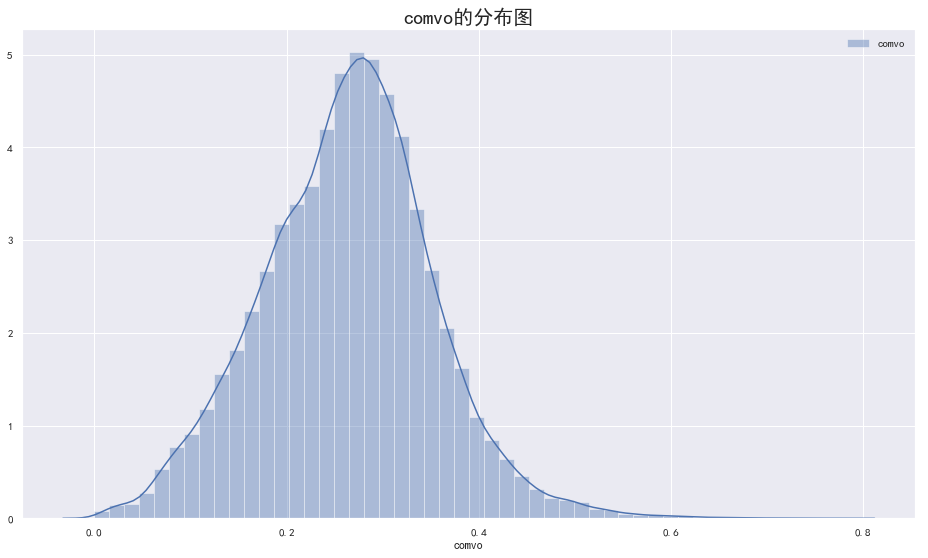

In [20]:
fig,ax=plt.subplots(figsize=(16,9))
sns.set(font='simhei')
# distplot绘制hist和kde
sns.distplot(df['comvo'],label='comvo')
plt.title('comvo的分布图',fontsize=20)
plt.legend()

#### 可以看到分布呈现明显的正态分布，那么comvo是否能表示电影的争议性程度呢？

#### 通过查看高comvo值的电影列表来佐证我们的想法:筛选出评论数大于30000，且comvo值在95分位数以上的电影列表

In [21]:
df[(df['comvo']>stats.scoreatpercentile(df['comvo'],95))&(df['comments']>20000)][['title','ReleaseDate','country','score','comments','comvo']].sort_values('ReleaseDate').sort_values('comvo',ascending=False)

,title,ReleaseDate,country,score,comments,comvo
42116,新喜剧之王,2019-02-05,中国/香港,5.8,78356.0,0.509219
36203,三生三世十里桃花,2017-08-03,中国,3.9,81930.0,0.494159
42087,流浪地球,2019-02-05,中国,7.9,473811.0,0.466153
36808,封神传奇,2016-07-29,香港/中国,2.9,21334.0,0.450922
42035,白蛇：缘起,2019-01-11,中国/美国,8.0,73401.0,0.440450
36698,长城 The Great Wall,2016-12-16,中国/美国,4.9,119111.0,0.434804
38909,西游伏妖篇,2017-01-28,中国/香港,5.5,117188.0,0.434006
38578,爵迹,2016-09-29,中国,3.8,46018.0,0.430509
48547,致青春·原来你还在这里,2016-07-08,中国,4.1,40213.0,0.418119
42085,阿丽塔：战斗天使 Alita: Battle Angel,2019-02-22,美国/加拿大/阿根廷,7.6,71303.0,0.415889


#### 粗略查看清单，可以看到2019之前的电影电影主要以低分电影居多，并且绝大多大多低分电影都遭受过不少口水。
#### 另外值得值得注意的是2019年春节前后竟然有4部电影出现在清单中（是不是流浪地球带来的流量提高了其它春节档电影的评论数啊2333)

#### 流浪地球通过.describe()查看comvo的大概分布状况，对比流浪地球的comvo值

In [22]:
index_of_earth=df[df['title'].str.contains('流浪地球')].index
comvo_of_earth=df['comvo'][index_of_earth]
print('流浪地球的comvo值:',comvo_of_earth)

流浪地球的comvo值: 42087    0.466153
Name: comvo, dtype: float64


In [23]:
pencentile_of_earth=stats.percentileofscore(a=df['comvo'],score=0.466153)
print('流浪地球comvo值的百分位数:{}'.format(pencentile_of_earth))

流浪地球comvo值的百分位数:98.41252844331414


#### 可以观察到，流浪地球的comvo比大于98.4%的电影.
#### 下图绘制了评论数大于10万条电影的comments和comvo的散点图，能够更直观地看出流浪地球的争议程度

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


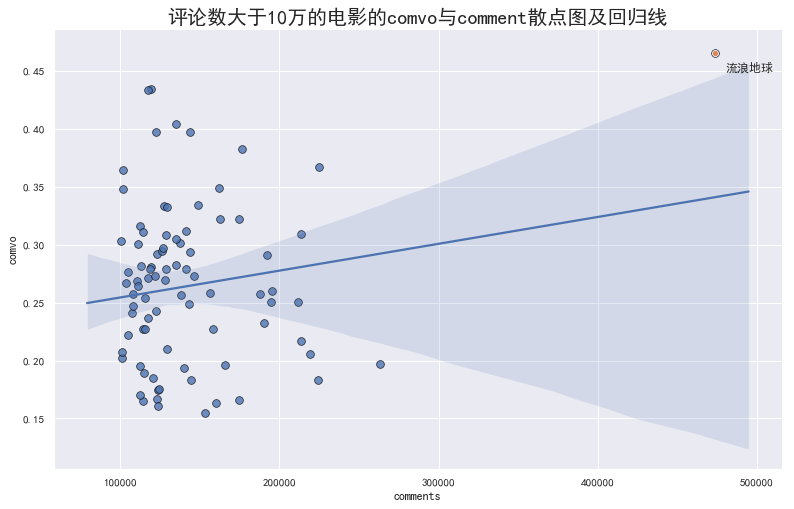

In [24]:
#fig,ax=plt.subplots(figsize=(16,9))
sns.set_style("dark")
sns.set(font="simhei")
df_10000=df[df['comments']>100000]
snsobj=sns.lmplot(x="comments", y="comvo", data=df_10000,
                     height=7, aspect=1.6, robust=True, palette='tab10',
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
snsobj=sns.scatterplot(x="comments",y="comvo",data=df_10000[df['title'].str.contains('流浪地球')])
plt.text(480008,0.45,'流浪地球')
plt.title('评论数大于10万的电影的comvo与comment散点图及回归线', fontsize=20)
plt.savefig('comvo-comment.jpg',dpi=300,bbox_inches='tight',edgecolor='k')

## 评论词频分析析

### 读取爬虫数据并进行数据清洗

In [25]:
comments=pd.read_json('D:/Onedrive/DS/JUPYTER/SCRAPY/Spider/women/EarthComments20.json')
comments_new=comments.applymap(lambda i:i[0])
for index in range(1,20):
    comments_subset=comments.applymap(lambda i:i[index])
    comments_new=pd.concat([comments_new,comments_subset],ignore_index=True)

In [26]:
comments_new.drop_duplicates(subset=['userID'],inplace=True)
comments_new['votes']=comments_new['votes'].astype('int')

comments_new['commentDate']=comments_new['commentDate'].apply(lambda i:i.replace('\n',''))
comments_new['score']=comments_new['score'].map({'很差':'一星','较差':'二星','还行':'三星','推荐':'四星','力荐':'五星'})
comments_new=comments_new.reset_index().drop('index',axis=1)
comments_new['commentDate']=pd.to_datetime(comments_new['commentDate'])
comments_new[:2]

,commentDate,content,score,userID,userName,votes
0,2019-01-28,还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...,一星,https://www.douban.com/people/duduxiongzhifu/,嘟嘟熊之父 🧸,69436
1,2019-02-05,想看科幻的，可以散了。想看父子冰释前嫌的，赶紧去吧。,一星,https://www.douban.com/people/165473726/,寻～,2036


### 统计全部评论的词频

In [27]:
import jieba
from dateutil.parser import parse

In [28]:
with open('seg.text','w',encoding='utf-8') as f:
    for item in comments_new['content']:
        f.write(item)

In [29]:
with open(r'D:/Onedrive/DS/JUPYTER/test/seg.text','r',encoding='utf-8') as f:
    list_seg=','.join(f)
df_seg=pd.DataFrame(jieba.lcut(list_seg))
df_seg.rename(columns={0:'wordsCount'},inplace=True)
#筛选字长至少为2的词语
df_seg['wordsCount']=df_seg[(df_seg['wordsCount'].str.len()>=2) & (df_seg['wordsCount']!='...')]
df_seg.dropna(inplace=True)
# 创建词频统计表
seg_count=pd.DataFrame(df_seg['wordsCount'].value_counts())
wordCountList=list(seg_count[seg_count['wordsCount']>20].index)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.923 seconds.
Prefix dict has been built succesfully.


In [30]:
seg_count=pd.DataFrame(df_seg['wordsCount'].value_counts())
print(seg_count[seg_count['wordsCount']>50].index)

Index(['中国', '科幻', '电影', '地球', '特效', '没有', '一个', '还是', '可以', '流浪', '真的', '就是',
       '不是', '煽情', '科幻片', '人类', '什么', '科幻电影', '最后', '人物', '故事', '台词', '这个',
       '剧情', '好莱坞', '吴京', '但是', '国产', '问题', '我们', '尴尬', '这种', '这部', '一部', '设定',
       '希望', '原著', '觉得', '看到', '宇宙', '拯救', '情感', '这样', '鼓励'],
      dtype='object')


### 从高频词中筛选出情感明显的词语，并计算哑变量，进行one-hot转换

In [31]:
#wordCountList=['中国','好莱坞','美国','科幻片','鼓励','特效','尴尬','煽情','科幻','国产','三星']

In [32]:
def splitContent(content):
    cutList=jieba.lcut(content)
    cutListSplited=[]
    for i in cutList:
        if i in wordCountList:
            cutListSplited.append(i)
    return cutListSplited

comments_new['wordSplit']=comments_new['content'].apply(splitContent)

zero_matrix=np.zeros((len(comments_new),len(wordCountList)))
dummies=pd.DataFrame(zero_matrix,columns=wordCountList)
dummies[:1]

,中国,科幻,电影,地球,特效,没有,一个,还是,可以,流浪,...,结果,郭帆,文化,除了,那个,地下城,主角,出现,真是,任何
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
for i,word in enumerate(comments_new.wordSplit):
    indices=dummies.columns.get_indexer(word)
    dummies.iloc[i,indices]=1

comments_new=comments_new.join(dummies)
comments_new[:1]

#### 对comments_new按score分组后进行均值预算，以消除个各分段数量不同的影响

In [46]:
comments_stack=comments_new.drop('votes',axis=1)
comments_stack=comments_stack.groupby(['score']).mean()
comments_stack=comments_stack.stack().reset_index().rename(columns={'level_1':'label',0:'value'})

Text(0, 0.5, '单条评论的出现概率')

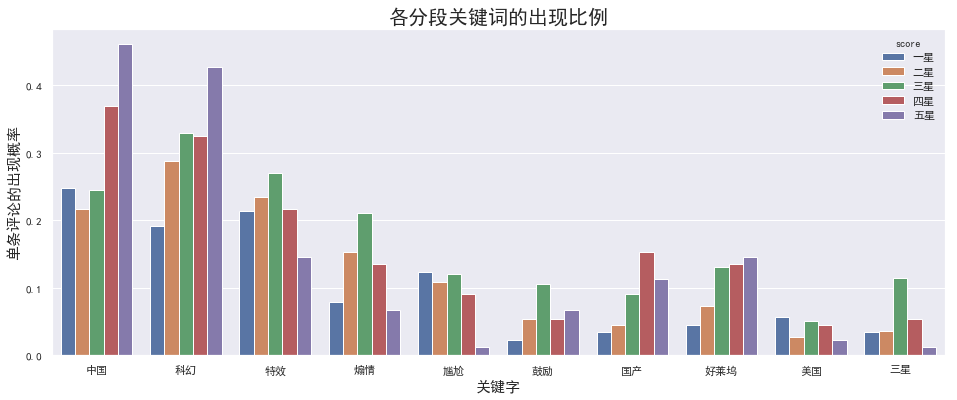

In [47]:
fig,ax=plt.subplots(figsize=(16,6))
sns.set(font='simhei')
wordOrder=['中国','科幻','特效','煽情','尴尬','鼓励','国产','好莱坞','美国','三星']
hue_order=['一星','二星','三星','四星','五星']
sns.barplot(data=comments_stack,x='label',y='value',hue='score',
            order=wordOrder,
            ax=ax,ci=None,hue_order=hue_order)
plt.title('各分段关键词的出现比例',fontsize=20)
plt.xlabel('关键字',fontsize=15)
plt.ylabel('单条评论的出现概率',fontsize=15)

### 从图中可以了解到以下信息：
- 5星评论中，几乎每两条评论就会有一条提到'中国'一词。
- 结合总次数可以看出，虽然科幻次数最高，但五星评论中的'中国'占比依旧是全场最高。
- "尴尬"在一到四星的单条评论中出现的概率都在0.1上下，但在五星评论里出现断崖式掉落。
- "特效"在五星评分的评论中的出现概率也远低于其余分段的评论。
- "煽情"的分布两端较低，三星出现概率最高。
- 分值与出现概率成正相关的关键词有:“中国”“科幻”，“特效”。
- "三星"是唯一的分值关键词，虽然处于三星的评分比例低于四星五星，至一点值得进一步分析。

# 分析结论

- 比较同分段(7.9分上下）,流浪地球的1星2星5星偏高，4星偏低。即流浪地球更容易得到一个极端评分。
- 相对低分评论，高评分评论更在意流浪地球的“中国科幻”的属性，并且相对不关注情感相关的方面。
- 观看过程中的"尴尬"可能是低分用户给出低分的一个重要原因。
- 流浪地球的三星评论虽然占比低于同分段电影，但可能是信息量最大的，并且评论内容更大概率给出自己的评分理由。值得进一步分析。